In [9]:
import numpy as np
import imageio as imio
import matplotlib.pyplot as plt

In [10]:
import tensorflow as tf

Si tienes algún error al ejecutar la celda anterior verifica que tu ambiente de anaconda tenga las librerías necesarias.

# Clasificación con K-nearest neighbors
En este notebook vamos a implementar K-nearest neighbor, nuestro algoritmo va a **clasificar** a que raza pertenece la imagen de un perro, para entrenar nuestro algoritmo vamos a utilizar un set de datos contiene imagenes de 120 razas de perros, en total son 10,222 imagenes.

Data: [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification/data)

#### Pre-procesamiento

El pre-procesamiento ya fue realizado y el dataset preparado y esta listo para usarse, para esto se aplico un proceso conocido como "transfer learning" usando la red neuronal "Inception" de Google(tema a cubrirse en proximas clases)  , para esta tarea ignoremos este detalle  y pensemos que se nos da un dataset con features donde cada columna representa una característica de entrada importante,pero no nos interesa conocer los detalles. 

Estas features/características fueron almacenadas en un matriz de numpy.

En esta parte del notebook solo hay que ejecutar las celdas para cargar los datos, estos datos van a servir de entrada para nuestra implementación de K-nearest neighbors con tensorflow.

### Referencias opcionales para transfer learning y "Google inception"
##### Inception
https://www.tensorflow.org/tutorials/image_recognition

https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html

##### Transfer Learning
https://www.datacamp.com/community/tutorials/transfer-learning

In [11]:
images_inception_features = './pre-processing/training_inception_features_array.npy'
training_image_labels_array = './pre-processing/training_image_labels_array.npy'
training_image_names_array = './pre-processing/training_image_names_array.npy'

In [12]:
TRAIN_DICTIONARY_KEYS = ["images", "label","features"]

training_set_dict = dict()
    
training_set_dict['images_name'] = np.load(training_image_names_array)
training_set_dict['label'] = np.load(training_image_labels_array)
training_set_dict['features'] = np.load(images_inception_features)


#  K-Nearest Neighbors

La data la vamos a manejar en los siguientes 3 arreglos: 

- features    : features de la imagen dadas por google Inception
- labels      : label de la imagen, identifica que raza es
- images_name : nombre de la imgen original, si descargan el dataset con link en la descripcion pueden buscar la imagen original por este nombre.

In [13]:
## Cargamos las features y las labes de cada feature
features = training_set_dict['features']
labels = training_set_dict['label']
images_name = training_set_dict['images_name']

In [14]:
len(features)
len(labels)
len(images_name)

10222

In [15]:
print("muestra del dataset", features)
print("rango del tensor", features.ndim)
print("tipo del tensor", type(features))
print("filas y columnas del tensor", features.shape)

muestra del dataset [[0.4150094  0.30133078 0.42465067 ... 0.05203951 0.13415624 0.50526893]
 [0.24543919 1.1325043  0.26326704 ... 0.47713736 0.06534781 0.07604624]
 [0.21103099 0.2277345  0.07869241 ... 0.24135002 0.15260082 0.13869573]
 ...
 [0.83136994 0.5540596  0.29159003 ... 0.12293872 0.02250517 0.54904526]
 [0.44555262 0.15933041 0.17165782 ... 0.22532606 0.28924143 1.8194226 ]
 [0.2348674  0.10243478 0.02458889 ... 0.17182411 2.0918512  0.13581699]]
rango del tensor 2
tipo del tensor <class 'numpy.ndarray'>
filas y columnas del tensor (10222, 2048)


Las labels pertenecientes a las features tienen el mismo indice, Ejemplo:

Caracteristicas X4:  [0.21987903 0.3616261  0.07786161 ... 0.34389263 1.2747684  0.29233742]
Caracteristicas X5:  [0.02053567 0.3619371  0.0674187  ... 0.18523939 0.5401145  0.0291276 ]
Label Y:  golden_retriever
Nombre:  0021f9ceb3235effd7fcde7f7538ed62


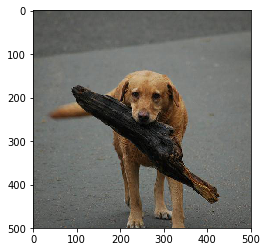

In [16]:
# Indice 4
print('Caracteristicas X4: ',features[4])
print('Caracteristicas X5: ',features[5])

print('Label Y: ',labels[4])

print('Nombre: ',images_name[4])

img = imio.imread('./data/train/'+images_name[4]+'.jpg')
plt.imshow(img)

### Implementa tu codigo de  K-Neighbors aqui:

El siguiente es un ejemplo de como puedes  definir tu función para predecir la raza sobre un punto x_predict ,a través de uscar los "k" vecinos mas cercanos en X_train y devolver como predicción el "y" que mas se repite(la moda) correspondiente a esos "k" valores de X_train , este "y" estará dado por Y_train.

Un ejemplo  de KNN en tensorflow: http://marubon-ds.blogspot.com/2017/09/knn-k-nearest-neighbors-by-tensorflow.html (este tiene diferencias, usar como guía no copiar literal, por ejemplo este usa una métrica de distancia diferente a la que debemos usar: distancia euclidiana )


#### Instrucciones:
1. Implementar KNN
2. Agregar el grafo de tensorboard
3. Ejecutar el modelo con las 2 imagenes de prueba.

In [17]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn import metrics
from sklearn.cluster import KMeans
#from sklearn.datasets import fetch_openml

from sklearn.decomposition import PCA

In [18]:
features.shape

(10222, 2048)

In [19]:
print("Columnas: ", features.shape[1])

Columnas:  2048


## Etiquetado de las razas y one hot

In [20]:
grafoonehot = tf.Graph()
with grafoonehot.as_default():
    ## definiendo el vector de nombres de razas como cosntantes
    etiquetas = tf.constant(labels)
    
    ## aplicando valores unicos
    ## la "y" da los valores unicos
    ## idx indexa cada valor unico haciendo que a lo largo de los
    ## datos cada valor unico tenga el mismo indice 
    yunicos, idx = tf.unique(etiquetas)
    
    ## haciendo one hot sobre los indicses idx
    hot = tf.one_hot(idx, depth = 120)
    
    ## calcula el maximo del indice para comprobar que indexo 120 razas
    maximo = tf.reduce_max(idx)
    

In [21]:
with tf.Session(graph = grafoonehot ) as sesiononehot:
    razas, indices, ceroyuno, mayor = sesiononehot.run([yunicos, idx, hot,maximo])
    #print("Unicos:", razas)
    print("Codigos nuevos:", indices)
    print("Maximo en los Codigos nuevos:", mayor)
    print("Codigo en one hot", ceroyuno)  

Codigos nuevos: [ 0  1  2 ... 63 77 92]
Maximo en los Codigos nuevos: 119
Codigo en one hot [[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [30]:
indices.shape

(10222,)

# PCA

In [26]:
#### PCA a 2 dimensiones ######
## implementar pca con sklearn
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(features) #es la matriz de caracteristicas


X2D = principalComponents #new features matrix

In [27]:
X2D.shape

(10222, 2)

In [28]:
print(features.shape) ## pasadomo de esta dimension 
print(X2D.shape) ## a esta dimension

(10222, 2048)
(10222, 2)


Text(0, 0.5, 'component 2')

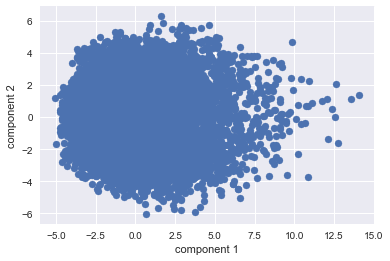

In [29]:
plt.scatter(X2D[:, 0], X2D[:, 1]) ## grafico la caractisticas las dos 
plt.xlabel('component 1')
plt.ylabel('component 2')

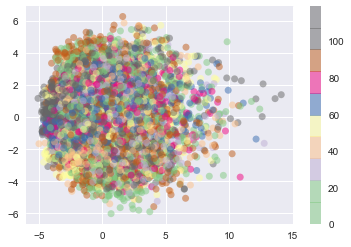

In [59]:
## no se perdio la carateristica cuando psamos de 64 a dos
plt.scatter(X2D[:, 0], X2D[:, 1],
            c=indices, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.colorbar()

## K-means Clustering con Sklearn

[Documentacion oficial](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [32]:
## K-means

In [33]:
kmeans = KMeans(n_clusters=120, random_state=0).fit(X2D) ## clustes de kmeans

In [34]:
kmeans.labels_

array([37, 51, 60, ..., 51, 10, 98])

In [35]:
kmeans.predict(X2D)

array([37, 51, 60, ..., 51, 10, 98])

In [36]:
kmeans.cluster_centers_.shape

(120, 2)

In [37]:
centers = kmeans.cluster_centers_
#clusters.cluster_centers_
print(centers)

[[-2.8322453   2.1217587 ]
 [ 2.7178135  -1.6308419 ]
 [-0.2216503  -1.5327712 ]
 [-2.4505832  -0.7177691 ]
 [ 1.3233951   1.8778099 ]
 [ 7.6311736  -0.66326493]
 [-1.5360703   2.7121036 ]
 [ 4.906909   -0.85286784]
 [-1.0496143  -3.186534  ]
 [ 0.14953177  1.3579761 ]
 [ 3.9867303   0.8888021 ]
 [-2.8262613  -2.9929411 ]
 [ 0.4653453   3.7161496 ]
 [ 1.1697079  -3.594281  ]
 [-1.9510046   0.6822265 ]
 [ 5.440483   -2.8688128 ]
 [ 6.7967534   3.3508258 ]
 [ 3.213101    4.0258307 ]
 [ 1.1736641  -0.34178954]
 [-0.6271546   0.19042438]
 [ 3.3958066  -3.3995051 ]
 [-0.8329036   2.9689512 ]
 [-2.3082368  -2.3499434 ]
 [-2.7678041  -0.07073105]
 [12.360364    0.5296699 ]
 [ 1.133604   -1.7149428 ]
 [ 2.0599313   0.12845635]
 [-4.046448    1.1789019 ]
 [-0.4455324  -2.315556  ]
 [-1.4364612   0.10032998]
 [-4.113174   -0.79322624]
 [-0.8319755   4.493524  ]
 [ 6.000419    0.23727284]
 [-1.2238191   0.9583289 ]
 [ 6.695371   -1.987234  ]
 [ 4.6466584   0.24105226]
 [ 0.03075308  2.8906243 ]
 

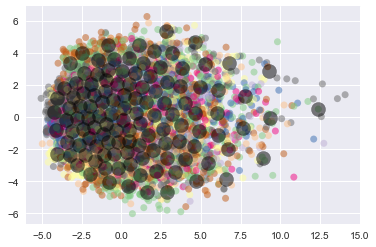

In [38]:
plt.scatter(X2D[:, 0], X2D[:, 1],
            c=indices, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.scatter(centers [:, 0], centers [:, 1], c='black', s=200, alpha=0.5);

## t-SNE

In [39]:
## esta llamanada sirve para la fucion que separara datos 
from sklearn.model_selection import train_test_split

In [40]:
## separacion de datos 
features_menor, test = train_test_split(features, test_size=0.50)

In [41]:
features_menor

array([[0.4183875 , 0.4860293 , 0.27010193, ..., 0.8998925 , 0.12325136,
        0.09987545],
       [0.76535773, 0.37364987, 0.16193381, ..., 0.42057526, 0.1439634 ,
        0.6790939 ],
       [0.40666503, 0.30326205, 0.46097434, ..., 0.19017257, 0.0186953 ,
        0.9754109 ],
       ...,
       [0.18106434, 0.18998146, 0.68813425, ..., 0.06770592, 0.517402  ,
        0.14150704],
       [0.36427128, 0.32757592, 0.2407094 , ..., 0.20385134, 0.14654808,
        0.3091779 ],
       [0.27358624, 0.15612511, 0.21876037, ..., 0.15132442, 0.01977841,
        0.24682121]], dtype=float32)

In [46]:
features_menor.shape

(5111, 2048)

In [47]:
from sklearn.manifold import TSNE

In [50]:
tsne = TSNE(n_components=2,n_iter=250)

In [51]:
componente_principal = tsne.fit_transform(features)

In [52]:
componente_principal

array([[ 1.2620187,  2.5192204],
       [ 2.8494225, -1.8710047],
       [-3.3800035, -2.276348 ],
       ...,
       [-3.61524  ,  2.6057937],
       [ 2.8469148,  1.6147484],
       [ 0.4870355,  0.285225 ]], dtype=float32)

## K-means Clustering con Sklearn

[Documentacion oficial](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [53]:
kmeanss = KMeans(n_clusters=120, random_state=0).fit(componente_principal) ## clustes de kmeans

In [54]:
kmeanss.labels_

array([105,  56,  13, ...,  84,  87,   2])

In [55]:
kmeanss.predict(componente_principal)

array([105,  56,  13, ...,  84,  87,   2])

In [56]:
kmeanss.cluster_centers_.shape

(120, 2)

In [57]:
centerss = kmeanss.cluster_centers_
#clusters.cluster_centers_
print(centerss)

[[ 3.8515036  -2.5017593 ]
 [-3.2251112  -0.32241398]
 [ 0.4386176   0.35292122]
 [-1.3521016  -2.3773801 ]
 [ 2.4476433   1.6174378 ]
 [ 4.989503    0.36738235]
 [-5.2658944   1.2748978 ]
 [ 1.1451735   2.4150982 ]
 [-2.6524522   1.6586759 ]
 [-0.14744985 -6.218151  ]
 [ 2.0235486  -1.024217  ]
 [ 0.21456394 -4.059067  ]
 [-0.34757167  3.421987  ]
 [-3.3060324  -2.4922113 ]
 [ 2.948801   -0.654375  ]
 [ 5.965891    1.1733513 ]
 [ 1.504125   -4.814651  ]
 [-3.6584928   2.3122973 ]
 [-0.01423041 -1.7845424 ]
 [-2.2380672   0.292614  ]
 [ 2.0566895   4.5129557 ]
 [-4.8784     -0.5091883 ]
 [ 1.7202991   0.25271922]
 [-3.9532013   0.8586141 ]
 [-1.7272522  -0.9660616 ]
 [-1.4514763  -3.9877129 ]
 [ 3.3719335   1.7094909 ]
 [ 3.3606596  -1.5056065 ]
 [-0.16901831  5.083292  ]
 [ 2.6511517   0.04347946]
 [ 4.1381288  -0.7581843 ]
 [-0.06072599 -0.7489453 ]
 [ 0.42931423 -3.1898205 ]
 [ 2.1023333   2.9798245 ]
 [-4.124845   -0.41380766]
 [ 1.058287    1.5449657 ]
 [ 2.7293484  -5.511323  ]
 

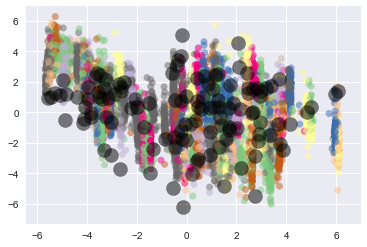

In [58]:
plt.scatter(componente_principal[:, 0], X2D[:, 1],
            c=indices, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.scatter(centerss [:, 0], centerss [:, 1], c='black', s=200, alpha=0.5);